<a href="https://colab.research.google.com/github/luca-arts/seeingtheimperceptible/blob/main/notebooks/ImageEditing/tests/LaMa_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

µ# 🦙 **LaMa: Resolution-robust Large Mask Inpainting with Fourier Convolutions**

[[Project page](https://saic-mdal.github.io/lama-project/)] [[GitHub](https://github.com/saic-mdal/lama)] [[arXiv](https://arxiv.org/abs/2109.07161)] [[Supplementary](https://ashukha.com/projects/lama_21/lama_supmat_2021.pdf)] [[BibTeX](https://senya-ashukha.github.io/projects/lama_21/paper.txt)]


Our model generalizes surprisingly well to much higher resolutions (~2k) than it saw during training (256x256), and achieves the excellent performance even in challenging scenarios, e.g. completion of periodic structures.

# 1. Preparations

Before start, make sure that you choose

- Runtime Type = Python 3
- Hardware Accelerator = GPU

In [1]:
!nvidia-smi

Wed Apr 20 15:23:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

1. linking next cloud

In [2]:
# we'll link the dataset from next-cloud
!curl https://raw.githubusercontent.com/luca-arts/seeingtheimperceptible/main/notebooks/database_mod.py -o /content/database_mod.py

from database_mod import *

link_nextcloud()

nextcloud = '/content/database/'

input_folder, output_folder = create_io(database=nextcloud,topic='ImageEditing',library='LaMa')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2235  100  2235    0     0  11951      0 --:--:-- --:--:-- --:--:-- 11951
what's the username for nextcloud? colab
what's the password for user colab? ··········
0
Please enter the username to authenticate with server
https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ or hit enter for none.
  Username: Please enter the password to authenticate user colab with server
https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ or hit enter for none.
  Password:  
content of /etc/fstab: https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ /content/database davfs user,rw,auto 0 0


2. Clone Git repository

In [15]:
import os
root_path = '/content/lama'

# clone the repository
if not os.path.exists(root_path):
  !git clone https://github.com/saic-mdal/lama {root_path}

%ls

Cloning into '/content/lama'...
remote: Enumerating objects: 306, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 306 (delta 45), reused 39 (delta 39), pack-reused 240
Receiving objects: 100% (306/306), 6.51 MiB | 10.30 MiB/s, done.
Resolving deltas: 100% (87/87), done.
'1224276_original (1).jpg'   conda_env.yml          LICENSE
 1224276_original.jpg        configs/               models/
 big-lama/                   data_for_prediction/   outputs/
 big-lama.zip                docker/                README.md
 bin/                        fetch_data/            requirements.txt
 colab/                      jpg_mask.png           saicinpainting/


3. Set up the environment

In [4]:
# setup req_path
# req_path = '/content/database/ImageEditing'
# %cd {req_path}

# Set up the environment
print('\n> Install dependencies')
# !pip install -r requirements-LaMa.txt --quiet
!pip install -r LaMa/requirements.txt --quiet


# do we need the wget?
!pip install wget --quiet

#print('\n> Changing the dir to:')



> Install dependencies
     |████████████████████████████████| 12.5 MB 8.8 MB/s 
     |████████████████████████████████| 22.3 MB 5.1 MB/s 
     |████████████████████████████████| 72 kB 658 kB/s 
     |████████████████████████████████| 144 kB 23.3 MB/s 
     |████████████████████████████████| 841 kB 55.6 MB/s 
     |████████████████████████████████| 271 kB 48.7 MB/s 
     |████████████████████████████████| 46 kB 2.0 MB/s 
     |████████████████████████████████| 948 kB 57.5 MB/s 
     |████████████████████████████████| 47.8 MB 51 kB/s 
     |████████████████████████████████| 112 kB 75.0 MB/s 
     |████████████████████████████████| 74 kB 4.0 MB/s 
     |████████████████████████████████| 136 kB 80.3 MB/s 
     |████████████████████████████████| 829 kB 66.5 MB/s 
     |████████████████████████████████| 596 kB 65.0 MB/s 
     |████████████████████████████████| 176 kB 73.0 MB/s 
     |████████████████████████████████| 1.1 MB 59.4 MB/s 
     |████████████████████████████████| 462 kB 39.8 MB/

4. Download the pre-trained model

In [16]:
%cd {root_path}

# download the model
print('\n> Download the model')
!curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o big-lama.zip
!unzip big-lama.zip

# fixing openCV
print('>fixing opencv')
!pip uninstall opencv-python-headless -y --quiet
!pip install opencv-python-headless==4.1.2.30 --quiet

/content/lama

> Download the model
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  363M    0  363M    0     0  9567k      0 --:--:--  0:00:38 --:--:-- 8679k
Archive:  big-lama.zip
  inflating: big-lama/config.yaml    
  inflating: big-lama/models/best.ckpt  
>fixing opencv


5. Init mask-drawing code

In [17]:
print('\n> Init mask-drawing code')
import base64, os
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
import wget
from shutil import copyfile
import shutil



canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)


> Init mask-drawing code


2. Inference

In [7]:
%ls

big-lama/     colab/         docker/      models/           saicinpainting/
big-lama.zip  conda_env.yml  fetch_data/  README.md
bin/          configs/       LICENSE      requirements.txt


In [8]:
fname = None
#fname = '/content/database/ImageEditing/input'

# fname = 'https://ic.pics.livejournal.com/mostovoy/28566193/1224276/1224276_original.jpg' # <-in the example
# fname = 'https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/1010286.jpeg'
# fname = 'https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/1010287.jpeg'
# fname = "https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/alex.jpg"

In [44]:
#@title copy the input images and convert them to PNG (as there is an issue with jpg for now)

import shutil, os, glob
!pip install Pillow
from PIL import Image

data_path = 'data_for_prediction'
#create directory
os.makedirs(data_path, exist_ok=True)
#look inside the source folder and copy only the jpgs
for filename in glob.glob(os.path.join(input_folder, '*.jpg')):
  #convert to png and save
  # im1 = Image.open(os.path.join(input_folder,filename))
  # save_path = os.path.join(data_path,filename.split('.')[-2].split('/')[-1]+'.png')
  # im1.save(save_path)
  #if you don't want to convert, only use next line
  shutil.copy(filename, data_path)

# print copied images:
for i in os.listdir(data_path):
  print(i)
img_choice = 1 #@param {type:"slider", min:0, max:6, step:1}
# You need this dumb name to get it working, sucking python code IMO
fname = './data_for_prediction/'+os.listdir(data_path)[img_choice]

8.jpg
4.jpg
7.jpg
5.jpg
6.jpg


Will use ./data_for_prediction/4.jpg for inpainting


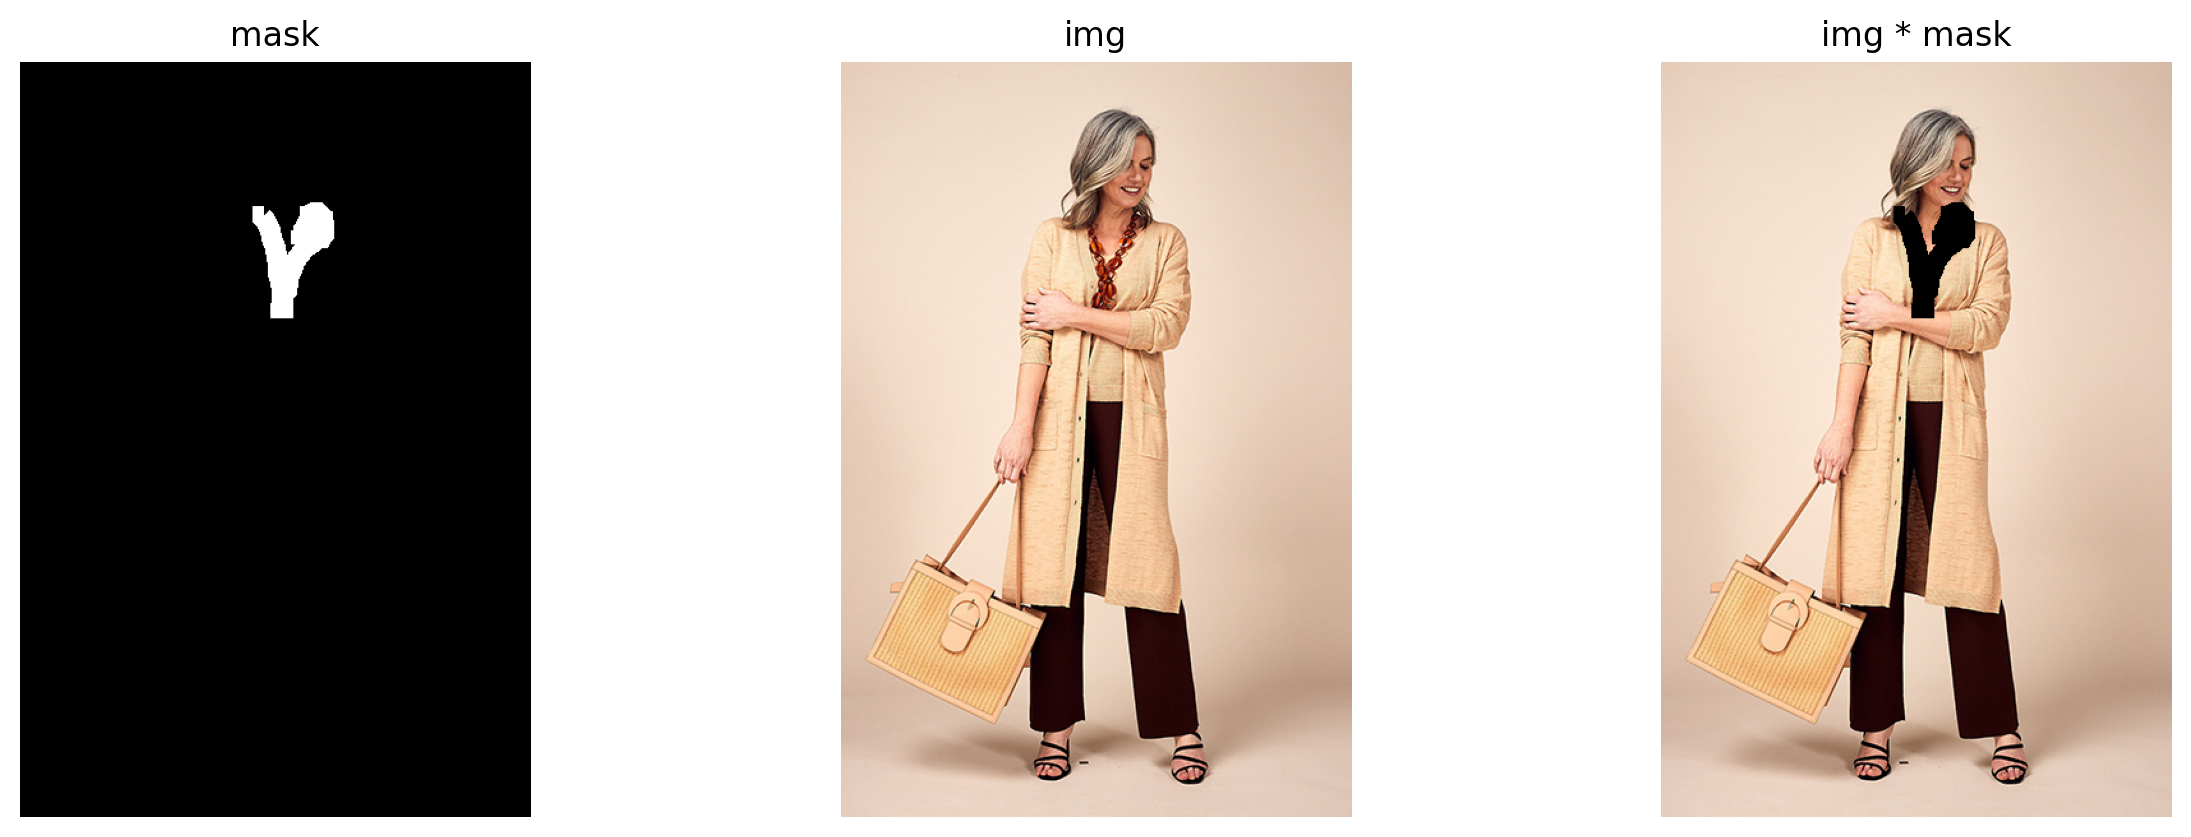

Run inpainting
100% 1/1 [00:00<00:00,  2.06it/s]
['1224276_original_mask.png', '5_mask.png', '4_mask.png']


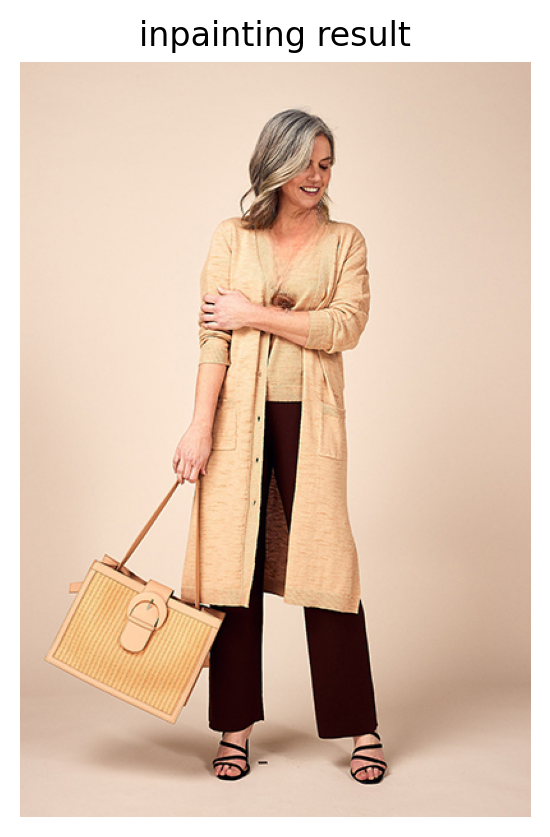

In [45]:

# title Draw a Mask, Press Finish, Wait for Inpainting

# needs to direct to the input folder on nextcloud

# if fname is None:
#   from google.colab import files
#   files = files.upload()
#   fname = list(files.keys())[0]
# else:
#   fname = wget.download(fname)

# Read input images from folder

'''import glob

fname = None

if fname is None:
  LM_files = glob.glob(input_folder + '/*.jpg')
  LM_files.sort()
  
  fname = LM_files[0]

  for file in LM_files:
    print("Reading Image ::: " + file)
else:
  print ('nothing to read/show')

shutil.rmtree('data_for_prediction', ignore_errors=True)
!mkdir data_for_prediction

# trim the path to image name
img_name = LM_files[0][-5:]

print('img_name ::: ', img_name)

copyfile(fname, f'data_for_prediction/{img_name}')
os.remove(fname)
fname = f'data_for_prediction/{img_name}'

print('fname2 ::: ', fname)
'''

image64 = base64.b64encode(open(fname, 'rb').read())
image64 = image64.decode('utf-8')

print(f'Will use {fname} for inpainting')
img = np.array(plt.imread(f'{fname}')[:,:,:3])

draw(image64, filename=f"./{fname.split('.')[1]}_mask.png", w=img.shape[1], h=img.shape[0], line_width=0.04*img.shape[1])
#@title Show a masked image and save a mask
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['figure.dpi'] = 200
plt.subplot(131)
with_mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png")[:,:,:3])
mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('mask')
plt.imsave(f"./{fname.split('.')[1]}_mask.png",mask, cmap='gray')

plt.subplot(132)
img = np.array(plt.imread(f'{fname}')[:,:,:3])
plt.imshow(img)
plt.axis('off')
plt.title('img')

plt.subplot(133)
img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(fname)[:,:,:3])
_=plt.imshow(img)
_=plt.axis('off')
_=plt.title('img * mask')
plt.show()

# os.makedirs('/content/output')

print('Run inpainting')
if '.jpeg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output dataset.img_suffix=.jpeg > /dev/null
elif '.jpg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.jpg   > /dev/null
elif '.png' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.png > /dev/null
else:
  print(f'Error: unknown suffix .{fname.split(".")[-1]} use [.png, .jpeg, .jpg]')

plt.rcParams['figure.dpi'] = 200

print(os.listdir('/content/output'))

plt.imshow(plt.imread(f"/content/output/{fname.split('.')[1].split('/')[2]}_mask.png"))
_=plt.axis('off')
_=plt.title('inpainting result')
plt.show()

fname = None